## Attribution

This code is adapted from Social Media Analytics (SIADS 682) Week 4 assignment. The original notebook was developed by Dr. Eric Gilbert
([eegg@umich.edu](mailto:eegg@umich.edu)).

The Winter 2023 course was taught by Erik Lang ([eriklang@umich.edu](mailto:eriklang@umich.edu)), with support from Jake Huang ([yiju@umich.edu](mailto:yiju@umich.edu)) and Alexander Levin-Koopman ([alevink@umich.edu](mailto:alevink@umich.edu)).


In [1]:
# !pip install matplotlib==3.8.1
# !pip install seaborn==0.13.0

import matplotlib
import seaborn

from langchain_core.documents import Document
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import pickle
import re
from typing import List, Tuple
import json
import textwrap


matplotlib.__version__, seaborn.__version__

('3.8.4', '0.13.2')

In [2]:
# Load from persistent store
persist_directory = "./../embeddings"

with open(f"{persist_directory}/transcripts.pickle", "rb") as handle:
    transcripts: List[Document] = pickle.load(handle)

transcripts[0]

Document(page_content="Once you know the Markov chain, generating the\nsequences becomes easy. You can also\ncalculate probability of any sequence\nbeing generated by the Markov chain as long as you know the initial probabilities and the transition probabilities. But problem is that if you\nare new to sequence modeling, if you have a new set of data, you actually don't know\nthe probabilities. It's not hard to find how\nmany states there are, basically you count\nhow many words there are in your vocabulary, or how many items there\nare in a DNA sequence. But you don't know the initial probabilities or the transition probabilities, we need to estimate\nthem from data. Basically, to use a Markov chain, we need to find the\ninitial probabilities, that is each word as the\nfirst word in sequence. What is the probability that we will see one word\nas the first word? You'd have a partial sequence\nor a complete sequence. For complete sequences, If we only care about generating\ncomplete sequ

In [3]:
import pandas as pd
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS

# fmt:off
CUSTOM_STOP_WORDS = ["www", "com", "https", "http", "siad"]
# fmt:on


def clean_tokenize_text(docs: List[Document]) -> pd.DataFrame:
    docs_df = pd.DataFrame([d.page_content for d in docs], columns=["text"])

    # docs_df["text"] = docs_df["text"].astype(str)

    docs_df["tokens"] = docs_df["text"].apply(
        lambda tokens: [
            t
            for t in preprocess_string(tokens)
            if t not in STOPWORDS and t not in CUSTOM_STOP_WORDS
        ]
    )

    return docs_df


tokens = clean_tokenize_text(transcripts)
tokens.head()

,text,tokens
0,"Once you know the Markov chain, generating the...","[know, markov, chain, gener, sequenc, easi, ca..."
1,Everything will be the same. How to estimate t...,"[estim, probabl, given, basic, need, count, ti..."
2,How so? Remember that if we care\nabout comple...,"[rememb, care, complet, sequenc, sss, state, c..."
3,You can do that.,[]
4,"In that case, you can basically introduce high...","[case, basic, introduc, higher, order, markov,..."


In [4]:
from gensim.models.phrases import Phrases, Phraser


def append_bigrams(docs_df):
    bigram_model = Phrases(docs_df["tokens"], min_count=20, delimiter="_")

    bigram_phraser = Phraser(bigram_model)

    docs_df["tokens"] = docs_df["tokens"].apply(lambda t: t + bigram_phraser[t])

    return docs_df


docs_tokens = clean_tokenize_text(transcripts)
docs_bigrams = append_bigrams(docs_tokens)
docs_bigrams["tokens"].head().values

array([list(['know', 'markov', 'chain', 'gener', 'sequenc', 'easi', 'calcul', 'probabl', 'sequenc', 'gener', 'markov', 'chain', 'long', 'know', 'initi', 'probabl', 'transit', 'probabl', 'problem', 'new', 'sequenc', 'model', 'new', 'set', 'data', 'actual', 'know', 'probabl', 'hard', 'state', 'basic', 'count', 'word', 'vocabulari', 'item', 'dna', 'sequenc', 'know', 'initi', 'probabl', 'transit', 'probabl', 'need', 'estim', 'data', 'basic', 'markov', 'chain', 'need', 'initi', 'probabl', 'word', 'word', 'sequenc', 'probabl', 'word', 'word', 'partial', 'sequenc', 'complet', 'sequenc', 'complet', 'sequenc', 'care', 'gener', 'complet', 'sequenc', 'try', 'gener', 'partial', 'sequenc', 'consid', 'start', 'sequenc', 'word', 'case', 'initi', 'probabl', 'valu', 'valu', 'state', 'word', 'care', 'partial', 'sequenc', 'assign', 'probabl', 'real', 'word', 'case', 'need', 'calcul', 'easili', 'calcul', 'wai', 'estim', 'unigram', 'languag', 'model', 'basic', 'count', 'time', 'word', 'appear', 'sequenc', 

In [5]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel


def find_topics(tokens, num_topics):
    # use gensim's Dictionary to filter words that appear less than ten times in the corpus
    # or represent more than 60% of the corpus
    dictionary = Dictionary(tokens)
    dictionary.filter_extremes(no_below=10, no_above=0.6)

    # use the dictionary to create a bag of word representation of each document
    corpus = [dictionary.doc2bow(text) for text in tokens]

    # create gensim's LDA model
    lda_model = LdaModel(
        num_topics=num_topics,
        corpus=corpus,
        id2word=dictionary,
        chunksize=2000,
        passes=20,
        iterations=400,
        eval_every=None,
        random_state=42,
        alpha="auto",
        eta="auto",
    )

    return lda_model.top_topics(corpus)


# docs_tokens = clean_tokenize_text(documents)
# docs_bigrams = append_bigrams(docs_tokens)
# find_topics(docs_bigrams["tokens"], num_topics=6)

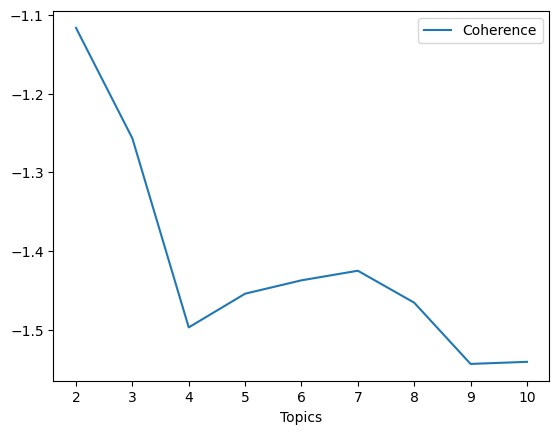

In [6]:
def calculate_avg_coherence(topics):
    avg_topic_coherence = sum([t[1] for t in topics]) / len(topics)

    return avg_topic_coherence


def plot_coherences_topics(tokens):
    # range of topics
    topics_range = range(2, 11, 1)
    model_results = {"Topics": [], "Coherence": []}
    for num_topics in topics_range:
        top_topics = find_topics(tokens.dropna(), num_topics=num_topics)

        avg_coherence = calculate_avg_coherence(top_topics)

        model_results["Topics"].append(num_topics)
        model_results["Coherence"].append(avg_coherence)

    pd.DataFrame(model_results).set_index("Topics").plot()


docs_tokens = clean_tokenize_text(transcripts)
docs_bigrams = append_bigrams(docs_tokens)
coherences_df = plot_coherences_topics(docs_bigrams["tokens"])

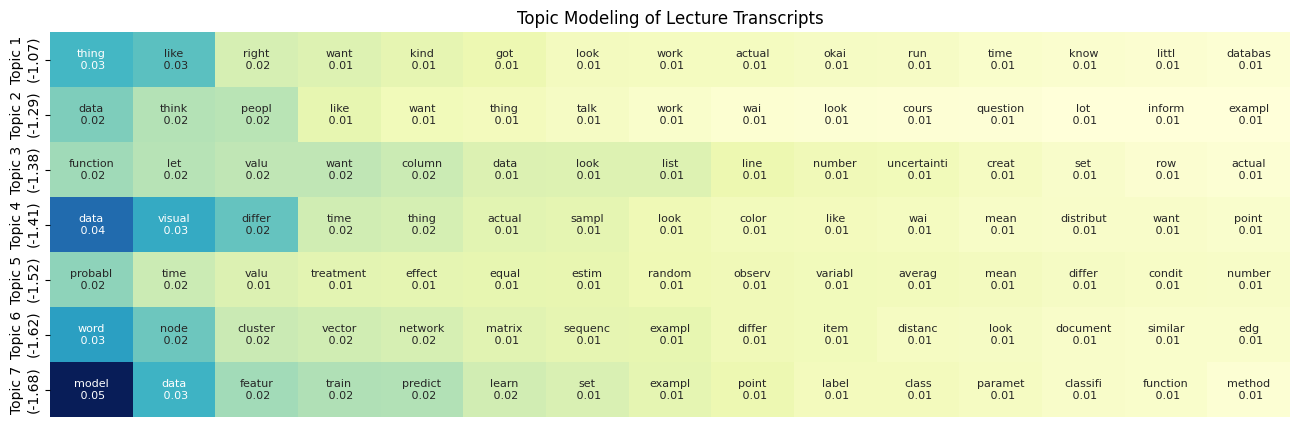

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_most_popular_topics(docs_df, num_topics, num_words):
    topics = find_topics(docs_df["tokens"], num_topics=num_topics)

    probs = []
    words = []
    coherences = []
    for topic in topics:
        topic_probs, coherence = topic
        probs.append([prob for prob, _ in topic_probs])
        words.append([word for _, word in topic_probs])
        coherences.append(coherence)

    df_probs = pd.DataFrame(probs, index=[i for i in range(len(probs))])
    df_words = pd.DataFrame(words, index=[i for i in range(len(words))])

    df_probs = df_probs.iloc[:, :num_words]
    df_words = df_words.iloc[:, :num_words]

    annotations = np.array(
        [
            f"{string}\n {value:.2f}"
            for string, value in zip(
                np.array(df_words).flatten(),
                np.array(df_probs).flatten(),
            )
        ]
    ).reshape(num_topics, num_words)

    plt.figure(figsize=(16, 5))
    ax = sns.heatmap(
        df_probs,
        annot=annotations,
        annot_kws={"fontsize": 8},
        fmt="",
        cmap="YlGnBu",
        cbar=False,
    )

    plt.title("Topic Modeling of Lecture Transcripts")
    yticklabels = [f"Topic {i}\n({c:.2f})" for i, c in enumerate(coherences, 1)]
    ax.set(xlabel=None, xticklabels=[], yticklabels=yticklabels)
    ax.tick_params(bottom=False)


docs_tokens = clean_tokenize_text(transcripts)
docs_bigrams = append_bigrams(docs_tokens)
plot_most_popular_topics(docs_bigrams, 7, 15)

|     | Topic                            |
| --- | -------------------------------- |
| 1   | General programming              |
| 2   | Data analysis and communication  |
| 3   | Data manipulation and processing |
| 4   | Data visualization               |
| 5   | Statistical analysis             |
| 6   | Text and network analysis        |
| 7   | Machine learning                 |
